<a href="https://colab.research.google.com/github/alejandrolq/StaticalLearningII-Proyecto/blob/main/ProyectoSLII_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nombre: José Alejandro López Quel**

**Carné: 21001127**

**Statistical Learning II**

**Sección U**

**Proyecto - Recurrent Neural Network**

In [63]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

In [64]:
path_name = '/content/drive/MyDrive/Statistical Learning II/Proyecto/Datasets/CNN'
file_name = 'SpiderData.csv'

In [65]:
data = pd.read_csv(os.path.join(path_name, file_name), encoding= 'unicode_escape', delimiter=";", header=None)

In [66]:
data.head()

,0,1
0,"¡Hola, \n@MaXx_imiliano\n! Gracias por compart...",1.jfif
1,"¡Hola, \n@catalina_parr\n! Gracias por tu cons...",2.jfif
2,"¡Hola, \n@maxxeff4\n! Gracias por compartir. P...",3.jfif
3,"¡Hola, \n@JavierG650ER\n! Gracias por tu consu...",4.jfif
4,"¡Hola, \n@headcrusher666\n! Gracias por tu con...",5.jfif


In [67]:
def format_tweet(column):
  x = re.sub('[^a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚÜ\.]', '', column)
  return (x.replace('\n', ''))

In [68]:
df = data.copy()
df[0] = df[0].apply(format_tweet)
df.head()

,0,1
0,Hola MaXximiliano Gracias por compartir. Perte...,1.jfif
1,Hola catalinaparr Gracias por tu consulta. Se ...,2.jfif
2,Hola maxxeff4 Gracias por compartir. Pertenece...,3.jfif
3,Hola JavierG650ER Gracias por tu consulta. Per...,4.jfif
4,Hola headcrusher666 Gracias por tu consulta. S...,5.jfif


In [69]:
df[0][1]

'Hola catalinaparr Gracias por tu consulta. Se trata de una integrante de la familia Araneidae del género Neoscona probablemente. No son consideradas de importancia médica NIMWhite heavy check mark Saludos'

In [70]:
def load_captions_data(path_name, df):
  caption_mapping = {}
  text_data = []

  for index, row in df.iterrows():
    img_name = os.path.join(path_name, row[1].strip())
    if img_name.endswith("jfif"):
      i = 0
      for cap in row[0].split('.'):
        if i == 0 and len(row[0].split('.'))!= 1 :
          pass
        else:
          caption = "<start> " + cap.strip() + " <end>"
          text_data.append(caption)
          if img_name in caption_mapping:
            caption_mapping[img_name].append(caption)
          else:
            caption_mapping[img_name] = [caption]
        i += 1
      if len(caption_mapping[img_name]) < 5:
        for i in range(5-len(caption_mapping[img_name])):
          caption_mapping[img_name].append(caption_mapping[img_name][i])
      elif len(caption_mapping[img_name]) > 5:
        for i in range(len(caption_mapping[img_name])-5):
          caption_mapping[img_name].pop(1)
  return caption_mapping, text_data

In [71]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
  all_images = list(caption_data.keys())
  if shuffle:
    np.random.shuffle(all_images)

  train_size = int(len(caption_data) * train_size)

  training_data = {
    img_name: caption_data[img_name] for img_name in all_images[:train_size]
  }
  validation_data = {
    img_name: caption_data[img_name] for img_name in all_images[train_size:]
  }
  return training_data, validation_data

In [72]:
captions_mapping, text_data = load_captions_data(path_name, df)
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  120
Number of validation samples:  30


In [73]:
len(captions_mapping['/content/drive/MyDrive/Statistical Learning II/Proyecto/Datasets/CNN/81.jfif'])

5

In [74]:
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
  max_tokens=10000,
  output_mode="int",
  output_sequence_length=20,
  standardize=custom_standardization,
)
vectorization.adapt(text_data)

image_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.3),
  ]
)

In [75]:
text_data[:10]

['<start> Pertenece a la familia Araneidae del género Neoscona probablemente <end>',
 '<start> Se les conoce como arañas de jardín o de tela orbicular <end>',
 '<start> No son consideradas de importancia médica NIMWhite heavy check mark <end>',
 '<start> Se trata de una integrante de la familia Araneidae del género Neoscona probablemente <end>',
 '<start> No son consideradas de importancia médica NIMWhite heavy check mark Saludos <end>',
 '<start> Pertenece a la familia Araneidae del género Neoscona probablemente <end>',
 '<start> No son consideradas de importancia médica NIMWhite heavy check mark Saludos <end>',
 '<start> Pertenece a la familia Theridiidae del género Steatoda probablemente <end>',
 '<start> No son consideradas de importancia médica NIMWhite heavy check mark Saludos <end>',
 '<start> Se trata de una integrante de la familia Araneidae <end>']

In [76]:
def read_image(img_path, size=(299, 299)):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, size)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [77]:
def make_dataset(images, captions, batch=64):
  img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
      read_image, num_parallel_calls=tf.data.AUTOTUNE
  )
  cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
      vectorization, num_parallel_calls=tf.data.AUTOTUNE
  )
  dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
  dataset = dataset.batch(batch).shuffle(256).prefetch(tf.data.AUTOTUNE)
  return dataset

In [78]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [79]:
train_dataset

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, None, 20)), types: (tf.float32, tf.int64)>

In [80]:
def get_cnn_model():
  # Utilizando un modelo pre-entrenado
  base_model = efficientnet.EfficientNetB0(
      input_shape=(*(299, 299), 3), include_top=False, weights="imagenet",
  )
  # Evitando que se reentrene el modelo inicial
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1, 1280))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)
  return cnn_model

class TransformerEncoderBlock(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = layers.Dense(embed_dim, activation="relu")
    self.layernorm_1 = layers.LayerNormalization()

  def call(self, inputs, training, mask=None):
    inputs = self.dense_proj(inputs)
    attention_output = self.attention(
        query=inputs, value=inputs, key=inputs, attention_mask=None
    )
    proj_input = self.layernorm_1(inputs + attention_output)
    return proj_input


class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim
    )
    self.position_embeddings = layers.Embedding(
        input_dim=sequence_length, output_dim=embed_dim
    )
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
  def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()

    self.embedding = PositionalEmbedding(
        embed_dim=512, sequence_length=20, vocab_size=10000
    )
    self.out = layers.Dense(10000)
    self.dropout_1 = layers.Dropout(0.1)
    self.dropout_2 = layers.Dropout(0.5)
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, training, mask=None):
    inputs = self.embedding(inputs)
    causal_mask = self.get_causal_attention_mask(inputs)
    inputs = self.dropout_1(inputs, training=training)

    if mask is not None:
      padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
      combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
      combined_mask = tf.minimum(combined_mask, causal_mask)

    attention_output_1 = self.attention_1(
        query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
    )

    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2 = self.attention_2(
      query=out_1,
      value=encoder_outputs,
      key=encoder_outputs,
      attention_mask=padding_mask,
    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    proj_out = self.layernorm_3(out_2 + proj_output)
    proj_out = self.dropout_2(proj_out, training=training)

    preds = self.out(proj_out)
    return preds

  def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
  def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5,):
    super().__init__()
    self.cnn_model = cnn_model
    self.encoder = encoder
    self.decoder = decoder
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.acc_tracker = keras.metrics.Mean(name="accuracy")
    self.num_captions_per_image = num_captions_per_image

  def calculate_loss(self, y_true, y_pred, mask):
    loss = self.loss(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

  def calculate_accuracy(self, y_true, y_pred, mask):
    accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
    accuracy = tf.math.logical_and(mask, accuracy)
    accuracy = tf.cast(accuracy, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

  def train_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0

    # 1. Get image embeddings
    img_embed = self.cnn_model(batch_img)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.
    for i in range(self.num_captions_per_image):
      with tf.GradientTape() as tape:
        # 3. Pass image embeddings to encoder
        encoder_out = self.encoder(img_embed, training=True)

        batch_seq_inp = batch_seq[:, i, :-1]
        batch_seq_true = batch_seq[:, i, 1:]

        # 4. Compute the mask for the input sequence
        mask = tf.math.not_equal(batch_seq_inp, 0)

        # 5. Pass the encoder outputs, sequence inputs along with
        # mask to the decoder
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=True, mask=mask
        )

        # 6. Calculate loss and accuracy
        caption_loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        caption_acc = self.calculate_accuracy(
            batch_seq_true, batch_seq_pred, mask
        )

        # 7. Update the batch loss and batch accuracy
        batch_loss += caption_loss
        batch_acc += caption_acc

      # 8. Get the list of all the trainable weights
      train_vars = (
          self.encoder.trainable_variables + self.decoder.trainable_variables
      )

      # 9. Get the gradients
      grads = tape.gradient(caption_loss, train_vars)

      # 10. Update the trainable weights
      self.optimizer.apply_gradients(zip(grads, train_vars))

    loss = batch_loss
    acc = batch_acc / float(self.num_captions_per_image)

    self.loss_tracker.update_state(loss)
    self.acc_tracker.update_state(acc)
    return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

  def test_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0

    # 1. Get image embeddings
    img_embed = self.cnn_model(batch_img)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.
    for i in range(self.num_captions_per_image):
      # 3. Pass image embeddings to encoder
      encoder_out = self.encoder(img_embed, training=False)

      batch_seq_inp = batch_seq[:, i, :-1]
      batch_seq_true = batch_seq[:, i, 1:]

      # 4. Compute the mask for the input sequence
      mask = tf.math.not_equal(batch_seq_inp, 0)

      # 5. Pass the encoder outputs, sequence inputs along with
      # mask to the decoder
      batch_seq_pred = self.decoder(
          batch_seq_inp, encoder_out, training=False, mask=mask
      )

      # 6. Calculate loss and accuracy
      caption_loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
      caption_acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

      # 7. Update the batch loss and batch accuracy
      batch_loss += caption_loss
      batch_acc += caption_acc

    loss = batch_loss
    acc = batch_acc / float(self.num_captions_per_image)

    self.loss_tracker.update_state(loss)
    self.acc_tracker.update_state(acc)
    return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

  @property
  def metrics(self):
    # We need to list our metrics here so the `reset_states()` can be
    # called automatically.
    return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=512, dense_dim=512, num_heads=2
)
decoder = TransformerDecoderBlock(
    embed_dim=512, ff_dim=512, num_heads=2
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

In [81]:
def plot_loss_accuracy(history, name=''):
  plt.figure(figsize=(12, 8))
  plt.subplot(2, 2, 1)
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label='val_Loss')
  plt.legend()
  plt.title('Loss evolution {}'.format(name))

  plt.subplot(2, 2, 2)
  plt.plot(history.history['acc'], label='accuracy')
  plt.plot(history.history['val_acc'], label='val_accuracy')
  plt.legend()
  plt.title('Accuracy evolution {}'.format(name))

In [82]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

caption_model.compile(optimizer='adam', loss=cross_entropy)

history_e1 = caption_model.fit(
  train_dataset,
  epochs=100,
  validation_data=valid_dataset,
  callbacks=[early_stopping]
)

Epoch 1/100
2/2 [==============================] - 82s 40s/step - loss: 30.7660 - acc: 0.1979 - val_loss: 16.5536 - val_acc: 0.5745
Epoch 2/100
2/2 [==============================] - 63s 35s/step - loss: 11.0566 - acc: 0.6244 - val_loss: 11.2285 - val_acc: 0.6487
Epoch 3/100
2/2 [==============================] - 63s 32s/step - loss: 7.0637 - acc: 0.7034 - val_loss: 10.0099 - val_acc: 0.6752
Epoch 4/100
2/2 [==============================] - 63s 35s/step - loss: 5.2750 - acc: 0.7530 - val_loss: 9.7271 - val_acc: 0.6826
Epoch 5/100
2/2 [==============================] - 63s 35s/step - loss: 4.1168 - acc: 0.7935 - val_loss: 9.7594 - val_acc: 0.6879
Epoch 6/100
2/2 [==============================] - 63s 35s/step - loss: 3.3450 - acc: 0.8169 - val_loss: 9.6652 - val_acc: 0.6996
Epoch 7/100
2/2 [==============================] - 63s 32s/step - loss: 2.8594 - acc: 0.8461 - val_loss: 9.7254 - val_acc: 0.7003
Epoch 8/100
2/2 [==============================] - 63s 35s/step - loss: 2.3418 - acc:

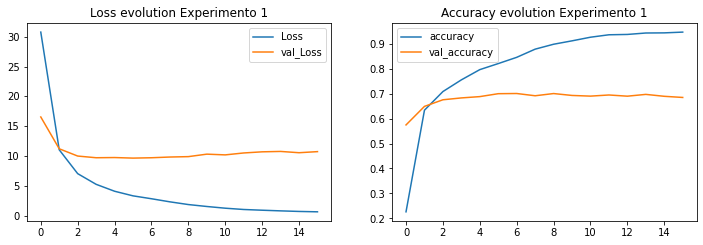

In [83]:
plot_loss_accuracy(history_e1, name='Experimento 1')

In [84]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# Compile the model
caption_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=cross_entropy
)

# Fit the model
history_e2 = caption_model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/100
2/2 [==============================] - 79s 35s/step - loss: 3.7328 - acc: 0.8096 - val_loss: 9.4909 - val_acc: 0.6848
Epoch 2/100
2/2 [==============================] - 62s 34s/step - loss: 2.7758 - acc: 0.8511 - val_loss: 9.7286 - val_acc: 0.7049
Epoch 3/100
2/2 [==============================] - 63s 35s/step - loss: 2.0499 - acc: 0.8867 - val_loss: 10.0567 - val_acc: 0.7035
Epoch 4/100
2/2 [==============================] - 62s 34s/step - loss: 1.5602 - acc: 0.9091 - val_loss: 10.3574 - val_acc: 0.6924
Epoch 5/100
2/2 [==============================] - 62s 31s/step - loss: 1.1969 - acc: 0.9307 - val_loss: 10.6189 - val_acc: 0.6969
Epoch 6/100
2/2 [==============================] - 62s 35s/step - loss: 0.9574 - acc: 0.9358 - val_loss: 11.0140 - val_acc: 0.6929
Epoch 7/100
2/2 [==============================] - 63s 31s/step - loss: 0.8186 - acc: 0.9440 - val_loss: 11.3874 - val_acc: 0.6963
Epoch 8/100
2/2 [==============================] - 62s 35s/step - loss: 0.7476 - acc:

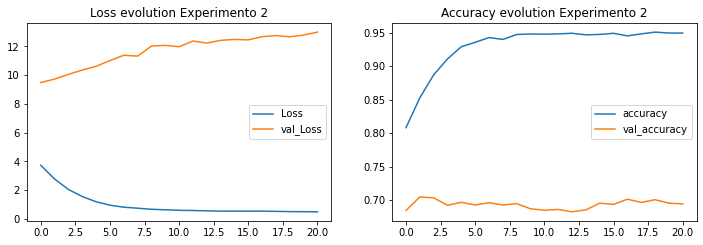

In [85]:
plot_loss_accuracy(history_e2, name='Experimento 2')

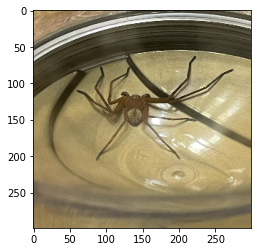

PREDICTED CAPTION: no son consideradas de importancia médica nimwhite heavy check mark saludos  antiveneno


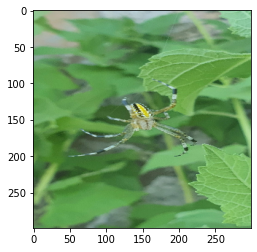

PREDICTED CAPTION: no son consideradas de importancia médica nimwhite heavy check mark saludos


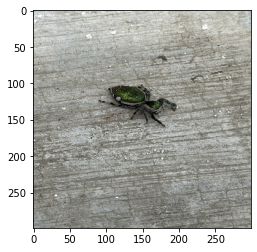

PREDICTED CAPTION: no son consideradas de importancia médica nimwhite heavy check mark saludos  antiveneno


In [86]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = 19
valid_images = list(valid_data.keys())


def generate_caption():
  # Select a random image from the validation dataset
  sample_img = np.random.choice(valid_images)

  # Read the image from the disk
  img_sample = sample_img
  sample_img = read_image(sample_img)
  img = sample_img.numpy().astype(np.uint8)
  plt.imshow(img)
  plt.show()

  # Pass the image to the CNN
  img = tf.expand_dims(sample_img, 0)
  img = caption_model.cnn_model(img)

  # Pass the image features to the Transformer encoder
  encoded_img = caption_model.encoder(img, training=False)

  # Generate the caption using the Transformer decoder
  decoded_caption = "<start> "
  for i in range(max_decoded_sentence_length):
    tokenized_caption = vectorization([decoded_caption])[:, :-1]
    mask = tf.math.not_equal(tokenized_caption, 0)
    predictions = caption_model.decoder(
      tokenized_caption, encoded_img, training=False, mask=mask
    )
    sampled_token_index = np.argmax(predictions[0, i, :])
    sampled_token = index_lookup[sampled_token_index]
    if sampled_token == " <end>":
      break
    decoded_caption += " " + sampled_token

  print("PREDICTED CAPTION:", end=" ")
  # print("Sample Image: " + str(img_sample))
  print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()